## Project 4: NLP: Google and Apple Sentiment Analysis
### Part 1: EDA and Data Viz

#### Introduction & Business Case
Welcome to the Phase 4 Project from Mark and Tim. 
We are MT Head: A marketing and PR firm that works with tech companies like Apple and Google. 
We help companies identify marketing and PR needs; product information requirements; alert them to possible customer service issues; and provide ideas for product teams (changes to features or new features and products).

Let’s do a little bit of time travel. The time is 2011. The place is Austin, Texas. The event is SXSW: the big music, movie, and tech conference. We have been hired to gather information on how conference attendees (at SXSW Interactive) are feeling about our clients products and services  - specifically Apple and Google. One way we have chosen to do that is to examine tweets during the conference. We are specifically interested in those tweets that are positive in nature (as this can tell us where the companies mission and products are resonating well with audiences) and tweets that are negative (so we can tell our clients where they need to change their messaging or products). 
For context, 2011 is when the iPad 2 came out; this is just after the Japan earthquake/tsunami/nuclear disaster occurred; Marisa Mayer (Google and Yahoo fame) was one of the speakers; etc.


#### The Data
In this project we used the dataset provided for the project. It is a set of tweets from 2011 during the SXSW Conference. The set includes 9093 tweets. Human raters first classified whether the tweet expressed a sentiment (3,548 were either poositive or negative, with the remainer being "none" or "can't tell"). Then, if an emotion was expressed, the human raters indicated whether the tweet was directed to either Apple or Google in general (1,091) or to a specific product from Apple (1,748) or Google (452). 

We started with a set of 9,093 tweets > narrowed down to 3,182
Focus on positive and negative sentiment only (not neutrals)
Focus on just tweets with product or company mentioned (Apple, Google)

Advantages of tweets: 
* timely
* event focused
* potentially lots of data (tweets) from many people
* limited length (so limits size of dataset)

Disadvantages of tweets: 
* Limited length often means limited context and understandability
* Special characters and shorthand writing style can make it hard to tell meaning
* Tweets at a conference can span a lot of irrelevent topics - travel, entertainment, free stuff, food
* Unsure of legitimacy of poster and accuracy of information


In [1]:
# Load the relevant libraries and modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

%matplotlib inline

# Set the basic plotting size; Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})
pd.set_option('display.max_columns', None)


[nltk_data] Downloading package punkt to /Users/markp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load the dataset (had to find correct coding to eliminate load error)
raw = pd.read_csv('tweet_product_company.csv', encoding = "ISO-8859-1")
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
raw.shape

(9093, 3)

In [5]:
raw.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# Simplify column names
raw.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'brand', 'is_there_an_emotion_directed_at_a_brand_or_product': 'feelings'}, inplace=True)

In [7]:
raw.head()

,text,brand,feelings
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
# Examine our class values - feelings
raw['feelings'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: feelings, dtype: int64

In [9]:
raw['brand'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand, dtype: int64

In [10]:
# Check for null values - recall that brand was only assigned for positive and negative tweets. 
print("Columns with null values")
display(raw.isnull().sum())

Columns with null values


text           1
brand       5802
feelings       0
dtype: int64

In [11]:
# Check for duplicated rows
duplicate = raw[raw.duplicated()]
duplicate.shape

(22, 3)

In [12]:
duplicate

,text,brand,feelings
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
4897,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,Positive emotion
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,NaN,No emotion toward brand or product
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",NaN,No emotion toward brand or product
5881,RT @mention Google to Launch Major New Social ...,NaN,No emotion toward brand or product


### Data cleanup and simplificiation
To keep things simple, we will narrow down the classes... just positive or negative sentiment, and I will collapse all specific products into just the 2 brands = Apple or Google.

In [13]:
raw2 = raw

In [14]:
# Brand consolidation step
company = {'iPad': 'Apple',
            'Apple': 'Apple',
            'iPad or iPhone App': 'Apple',
            'Google': 'Google',
            'iPhone': 'Apple',
            'Other Google product or service': 'Google',
            'Android App': 'Google',
            'Android': 'Google',
            'Other Apple product or service': 'Apple'}
raw2['brand'] = raw2['brand'].map(company)

In [15]:
raw2['brand'].value_counts()

Apple     2409
Google     882
Name: brand, dtype: int64

In [16]:
raw3 = raw2

In [17]:
# Feelings class simplification (drop 2)
raw3.drop(raw3[raw3['feelings'] == "I can't tell"].index, inplace = True)
raw3.drop(raw3[raw3['feelings'] == "No emotion toward brand or product"].index, inplace = True)
raw3['feelings'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: feelings, dtype: int64

In [18]:
# Change 'feelings' to numeric labels
feels = {'Negative emotion': 0,'Positive emotion': 1,}
raw3['feelings'] = raw3['feelings'].map(feels)

1    2978
0     570
Name: feelings, dtype: int64


<AxesSubplot:xlabel='feelings', ylabel='count'>

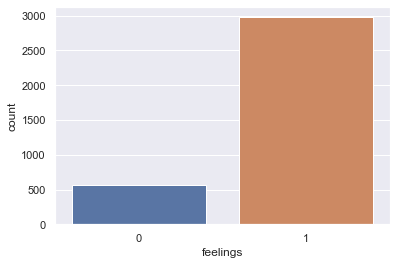

In [19]:
# Doing some visualization of our classes: not very balanced.
print (raw3['feelings'].value_counts())
sns.countplot(x = 'feelings', data = raw3)

Apple     2337
Google     854
Name: brand, dtype: int64


<AxesSubplot:xlabel='brand', ylabel='count'>

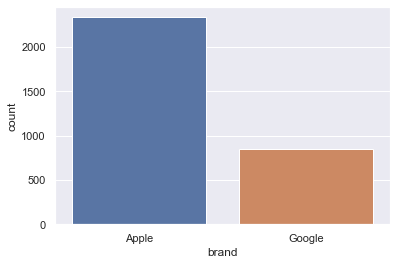

In [20]:
print (raw3['brand'].value_counts())
sns.countplot(x = 'brand', data = raw3)

<AxesSubplot:xlabel='brand'>

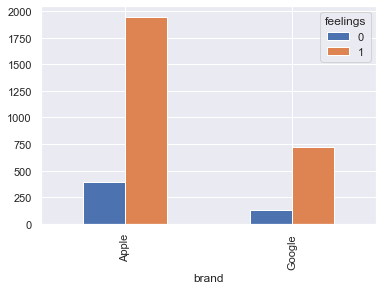

In [21]:
pd.crosstab(raw3['brand'],raw3['feelings']).plot.bar()

In [22]:
raw3.head()

,text,brand,feelings
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1
3,@sxsw I hope this year's festival isn't as cra...,Apple,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1


In [23]:
raw3.shape

(3548, 3)

In [24]:
# Check for null values
print("Columns with null values")
display(raw3.isnull().sum())

Columns with null values


text          0
brand       357
feelings      0
dtype: int64

In [25]:
# Check for duplicated rows
duplicate = raw3[raw3.duplicated()]
duplicate.shape

(9, 3)

In [26]:
raw4 = raw3

In [27]:
# drop the missing values in the brand column
raw4.dropna(subset=['brand'], inplace=True)
raw4.shape

(3191, 3)

In [28]:
# Check for duplicated rows
duplicate = raw4[raw4.duplicated()]
duplicate.shape

(9, 3)

In [29]:
raw5=raw4

In [30]:
# Drop duplicate rows
raw5.drop_duplicates(keep='first',inplace=True)
raw5.shape

(3182, 3)

In [31]:
print (raw5['feelings'].value_counts())
print (raw5['brand'].value_counts())

1    2664
0     518
Name: feelings, dtype: int64
Apple     2332
Google     850
Name: brand, dtype: int64


<AxesSubplot:xlabel='brand'>

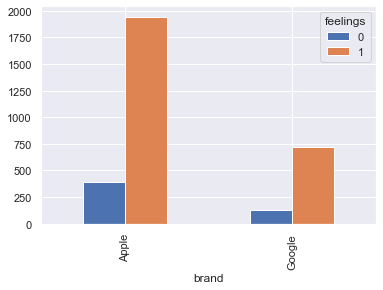

In [32]:
pd.crosstab(raw5['brand'],raw5['feelings']).plot.bar()

<AxesSubplot:xlabel='feelings'>

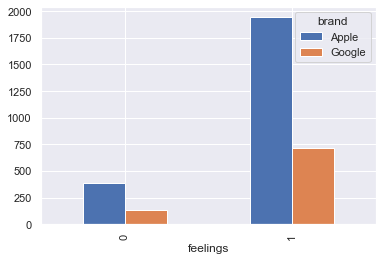

In [33]:
pd.crosstab(raw5['feelings'],raw5['brand']).plot.bar()

In [83]:
raw5.groupby('brand').count()

,text,feelings,text_fixed,char_count,stopwords
brand,,,,,
Apple,2332,2332,2332,2332,2332
Google,850,850,850,850,850


In [84]:
raw5.groupby('feelings').count()

,text,brand,text_fixed,char_count,stopwords
feelings,,,,,
0,518,518,518,518,518
1,2664,2664,2664,2664,2664


### Observations after initial data cleaning and simplifying
By simplifying the classes and cleaning nulls and duplicates we have gone from 9093 to 3182 observations. As a result we have 2 classes of sentiments (0=negative; 1=positive) and 2 classes of brands (Apple and Google). There is a class imbance for each of these. The main one of concern is sentiment where positive sentiment makes up 84% of our tweets (16% is negative). Note sure how this will affect our models at this point. We may need to SMOTE.

### Criteria for Model Evaluation
We want to identify both positive and negative things people are saying about our clients and their services. However, we are more concerned with the negative things people are saying as these are areas for improvement, and in some cases may need immediate attention. 

So we are concerned with model ACCURACY… for sure. But in addition to that, we are also concerned with RECALL (for the minority class - negative tweets) … as we don't wan’t to miss negative things that get predicted /coded as positive. Initially we have coded the negative class as 0 and the positive as 1. We may need to change that in the modeling phase - TBD. 

In [34]:
raw5.head(2)

,text,brand,feelings
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1


In [98]:
raw5.text[1]

"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"

### Text normalization and clean-up
As part of this step I will follow some steps outlined from AmberLynn Yandow's notebook. This includes creating a seperate column in the df for the cleaned text. 

In [36]:
#Getting rid of upper cases. This avoids having multiple copies of the same words 
raw5['text_fixed'] = raw5['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
raw5['text_fixed'].head()

0    .@wesley83 i have a 3g iphone. after 3 hrs twe...
1    @jessedee know about @fludapp ? awesome ipad/i...
2    @swonderlin can not wait for #ipad 2 also. the...
3    @sxsw i hope this year's festival isn't as cra...
4    @sxtxstate great stuff on fri #sxsw: marissa m...
Name: text_fixed, dtype: object

In [37]:
#Removing punctuation. To reduce the size of the data 
raw5['text_fixed'] = raw5['text_fixed'].str.replace('[^\w\s]','')
raw5['text_fixed'].head()

0    wesley83 i have a 3g iphone after 3 hrs tweeti...
1    jessedee know about fludapp  awesome ipadiphon...
2    swonderlin can not wait for ipad 2 also they s...
3    sxsw i hope this years festival isnt as crashy...
4    sxtxstate great stuff on fri sxsw marissa maye...
Name: text_fixed, dtype: object

In [38]:
# Take a look at standard stop word list
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [39]:
len(stop)

179

In [41]:
#how many characters in each tweet? 
raw5['char_count'] = raw5['text_fixed'].str.len() 
print(raw5[['text_fixed','char_count']].head())
print(raw5['char_count'].mean())

                                          text_fixed  char_count
0  wesley83 i have a 3g iphone after 3 hrs tweeti...         117
1  jessedee know about fludapp  awesome ipadiphon...         130
2  swonderlin can not wait for ipad 2 also they s...          74
3  sxsw i hope this years festival isnt as crashy...          76
4  sxtxstate great stuff on fri sxsw marissa maye...         117
98.95065996228787


In [42]:
#how many stop words are there per tweet? 
raw5['stopwords'] = raw5['text_fixed'].apply(lambda x: len([x for x in x.split() if x in stop]))
raw5[['text_fixed','stopwords']].head(10)

,text_fixed,stopwords
0,wesley83 i have a 3g iphone after 3 hrs tweeti...,10
1,jessedee know about fludapp awesome ipadiphon...,5
2,swonderlin can not wait for ipad 2 also they s...,8
3,sxsw i hope this years festival isnt as crashy...,5
4,sxtxstate great stuff on fri sxsw marissa maye...,1
7,sxsw is just starting ctia is around the corne...,15
8,beautifully smart and simple idea rt madebyman...,4
9,counting down the days to sxsw plus strong can...,5
10,excited to meet the samsungmobileus at sxsw so...,9
11,find amp start impromptu parties at sxsw with ...,5


In [43]:
print(raw5['stopwords'].mean())

5.674418604651163


In [45]:
raw5.head(5)

,text,brand,feelings,text_fixed,char_count,stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,wesley83 i have a 3g iphone after 3 hrs tweeti...,117,10
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,jessedee know about fludapp awesome ipadiphon...,130,5
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,swonderlin can not wait for ipad 2 also they s...,74,8
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,sxsw i hope this years festival isnt as crashy...,76,5
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff on fri sxsw marissa maye...,117,1


In [46]:
# Adding unique things to stopword list. 
stop += ['link', 'quot', 'com', 'rt', 'mention', 'amp', 'sxsw', 'sxtx', '@mention']
stop_set = set(stop)

In [47]:
#removing stopwords 
raw5['text_fixed'] = raw5['text_fixed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_set))
raw5['text_fixed'].head()

0    wesley83 3g iphone 3 hrs tweeting rise_austin ...
1    jessedee know fludapp awesome ipadiphone app y...
2                     swonderlin wait ipad 2 also sale
3     hope years festival isnt crashy years iphone app
4    sxtxstate great stuff fri marissa mayer google...
Name: text_fixed, dtype: object

In [48]:
raw5.head()

,text,brand,feelings,text_fixed,char_count,stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,wesley83 3g iphone 3 hrs tweeting rise_austin ...,117,10
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,jessedee know fludapp awesome ipadiphone app y...,130,5
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,swonderlin wait ipad 2 also sale,74,8
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,hope years festival isnt crashy years iphone app,76,5
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri marissa mayer google...,117,1


In [101]:
#most frequent words overall - hmmm lots of product names and general superlatives
freq = pd.Series(' '.join(raw5['text_fixed']).split()).value_counts()[:25]
freq

ipad       1068
apple       863
google      666
iphone      603
store       532
2           492
app         408
new         357
austin      283
popup       210
ipad2       194
android     193
get         167
launch      157
like        134
great       131
via         131
line        131
time        130
social      126
one         122
cool        118
im          117
circles     112
party       112
dtype: int64

In [51]:
raw6 = raw5

In [52]:
raw6.head()

,text,brand,feelings,text_fixed,char_count,stopwords
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,wesley83 3g iphone 3 hrs tweeting rise_austin ...,117,10
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,jessedee know fludapp awesome ipadiphone app y...,130,5
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,swonderlin wait ipad 2 also sale,74,8
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,hope years festival isnt crashy years iphone app,76,5
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri marissa mayer google...,117,1


### Update: Include more stop words
After some additional post modeling EDA decided to cut some of the really common words from our texts. Doing this on the raw6 dataset. 

In [105]:
# Adding MORE unique things to stopword list. 
stop += ['link', 'quot', 'com', 'rt', 'mention', 'amp', 'sxsw', 'sxtx', '@mention', 'sxswi', 'store', 'link', 'http', '2', 'sxswrt', 'google', 'googles', 'app', 'apps', 'android', 'austin', 'quotgoogle', 'new', 'today', 'one', 'apple', 'ipad', 'ipads', 'iphone', 'ipad2', 'apples', 'quotapple']
stop_set = set(stop)

In [106]:
#removing stopwords 
raw6['text_fixed'] = raw6['text_fixed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_set))
raw6['text_fixed'].head()

0    wesley83 3g 3 hrs tweeting rise_austin dead ne...
1    jessedee know fludapp awesome ipadiphone youll...
2                            swonderlin wait also sale
3                hope years festival isnt crashy years
4    sxtxstate great stuff fri marissa mayer tim or...
Name: text_fixed, dtype: object

In [107]:
#most frequent words overall - after cutting out additional unique stopwords
freq = pd.Series(' '.join(raw6['text_fixed']).split()).value_counts()[:25]
freq

popup        210
get          167
launch       157
like         134
great        131
via          131
line         131
time         130
social       126
cool         118
im           117
party        112
circles      112
day          105
free         103
maps         103
go           102
love          97
good          96
people        95
awesome       91
dont          89
temporary     88
opening       87
mobile        85
dtype: int64

### Diversion...Take a look at sentiment using TextBlob
We wanted to see how well an existing library / tool could detect sentiment in our set of tweets. Note that there are 2 scores here from TextBlob: polarity (how negative or positive it is on scale of -1 to +1; and subjectivity which is on a 0 to 1 scale with 1 being objective and 0 being subjective. UPDATED with raw6.

In [85]:
# Calculate the values and add them to our df.
raw5['polarity'] = raw5['text_fixed'].apply(lambda x: TextBlob(x).sentiment[0])
raw5['subjectivity'] = raw5['text_fixed'].apply(lambda x: TextBlob(x).sentiment[1])
raw5.head()

,text,brand,feelings,text_fixed,char_count,stopwords,polarity,subjectivity
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,wesley83 3g iphone 3 hrs tweeting rise_austin ...,117,10,-0.200000,0.400000
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,jessedee know fludapp awesome ipadiphone app y...,130,5,0.466667,0.933333
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,swonderlin wait ipad 2 also sale,74,8,0.000000,0.000000
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,hope years festival isnt crashy years iphone app,76,5,0.000000,0.000000
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri marissa mayer google...,117,1,0.800000,0.750000


In [88]:
# Create a table of summary stats for our whole df and can group by 'brand' or 'feelings.'
# display (raw5[raw5['brand'] == "Apple"] [['brand', 'polarity', 'subjectivity']].groupby ('brand').agg([np.mean, np.max, np.minimum, np.median]))
# raw5[raw5['brand'] == "Google"] [['brand', 'polarity', 'subjectivity']].groupby ('brand').agg([np.mean, np.max, np.minimum, np.median])

In [89]:
raw5.describe()

,feelings,char_count,stopwords,polarity,subjectivity
count,3182.000000,3182.000000,3182.000000,3182.000000,3182.000000
mean,0.837209,98.950660,5.674419,0.180310,0.394471
std,0.369233,26.099363,3.045226,0.302532,0.321865
min,0.000000,23.000000,0.000000,-1.000000,0.000000
25%,1.000000,81.000000,3.000000,0.000000,0.000000
50%,1.000000,103.000000,5.000000,0.116553,0.425000
75%,1.000000,120.000000,8.000000,0.350000,0.642857
max,1.000000,153.000000,17.000000,1.000000,1.000000


In [90]:
raw5.groupby('brand').describe()

feelings                                              char_count  \
          count      mean       std  min  25%  50%  75%  max      count   
brand                                                                     
Apple    2332.0  0.834048  0.372117  0.0  1.0  1.0  1.0  1.0     2332.0   
Google    850.0  0.845882  0.361274  0.0  1.0  1.0  1.0  1.0      850.0   

                                                               stopwords  \
              mean        std   min   25%    50%    75%    max     count   
brand                                                                      
Apple    97.996569  26.169365  23.0  79.0  102.0  119.0  153.0    2332.0   
Google  101.568235  25.740495  24.0  83.0  107.0  121.0  151.0     850.0   

                                                     polarity            \
            mean       std  min  25%  50%  75%   max    count      mean   
brand                                                                     
Apple   6.008148  3.070378  0.0  4.0  6.0  8.0  17.0   2332.0  0.175830   
Google  4.758824  2.777912  0.0  3.0  4.0  7.0  15.0    850.0  0.192602   

                                                    subjectivity            \
             std  min  25%       50%       75%  max        count      mean   
brand                                                                        
Apple   0.303132 -1.0  0.0  0.100000  0.350000  1.0       2332.0  0.393394   
Google  0.300715 -1.0  0.0  0.136364  0.358929  1.0        850.0  0.397427   

                                                          
             std  min       25%       50%       75%  max  
brand                                                     
Apple   0.326526  0.0  0.000000  0.428451  0.650000  1.0  
Google  0.308885  0.0  0.071429  0.408333  0.601515  1.0

In [91]:
raw5.groupby('feelings').describe()

char_count                                                          \
              count        mean        std   min   25%    50%    75%    max   
feelings                                                                      
0             518.0  102.345560  26.315786  33.0  84.0  106.0  125.0  148.0   
1            2664.0   98.290541  26.010621  23.0  80.0  102.0  119.0  153.0   

         stopwords                                               polarity  \
             count      mean       std  min  25%  50%  75%   max    count   
feelings                                                                    
0            518.0  6.249035  3.198426  0.0  4.0  6.0  8.0  16.0    518.0   
1           2664.0  5.562688  3.002411  0.0  3.0  5.0  8.0  17.0   2664.0   

                                                                      \
              mean       std  min       25%       50%       75%  max   
feelings                                                               
0         0.029767  0.334095 -1.0 -0.041667  0.000000  0.183333  1.0   
1         0.209582  0.287043 -1.0  0.000000  0.136364  0.375000  1.0   

         subjectivity                                                         
                count      mean       std  min  25%       50%       75%  max  
feelings                                                                      
0               518.0  0.366644  0.330473  0.0  0.0  0.316667  0.600000  1.0  
1              2664.0  0.399882  0.319947  0.0  0.0  0.438636  0.642857  1.0

In [108]:
# RE-Run this with raw6... which has more stop words cut out. 
# Calculate the values and add them to our df.
raw6['polarity'] = raw6['text_fixed'].apply(lambda x: TextBlob(x).sentiment[0])
raw6['subjectivity'] = raw6['text_fixed'].apply(lambda x: TextBlob(x).sentiment[1])
raw6.head()

,text,brand,feelings,text_fixed,char_count,stopwords,polarity,subjectivity
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,0,wesley83 3g 3 hrs tweeting rise_austin dead ne...,117,10,-0.200000,0.400000
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,1,jessedee know fludapp awesome ipadiphone youll...,130,5,0.466667,0.933333
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,1,swonderlin wait also sale,74,8,0.000000,0.000000
3,@sxsw I hope this year's festival isn't as cra...,Apple,0,hope years festival isnt crashy years,76,5,0.000000,0.000000
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri marissa mayer tim or...,117,1,0.800000,0.750000


In [109]:
raw6.groupby('brand').describe()

feelings                                              char_count  \
          count      mean       std  min  25%  50%  75%  max      count   
brand                                                                     
Apple    2332.0  0.834048  0.372117  0.0  1.0  1.0  1.0  1.0     2332.0   
Google    850.0  0.845882  0.361274  0.0  1.0  1.0  1.0  1.0      850.0   

                                                               stopwords  \
              mean        std   min   25%    50%    75%    max     count   
brand                                                                      
Apple    97.996569  26.169365  23.0  79.0  102.0  119.0  153.0    2332.0   
Google  101.568235  25.740495  24.0  83.0  107.0  121.0  151.0     850.0   

                                                     polarity            \
            mean       std  min  25%  50%  75%   max    count      mean   
brand                                                                     
Apple   6.008148  3.070378  0.0  4.0  6.0  8.0  17.0   2332.0  0.175936   
Google  4.758824  2.777912  0.0  3.0  4.0  7.0  15.0    850.0  0.188885   

                                                    subjectivity            \
             std  min  25%       50%       75%  max        count      mean   
brand                                                                        
Apple   0.315734 -1.0  0.0  0.065476  0.350000  1.0       2332.0  0.384577   
Google  0.310557 -1.0  0.0  0.114062  0.372917  1.0        850.0  0.384452   

                                                  
             std  min  25%       50%    75%  max  
brand                                             
Apple   0.340129  0.0  0.0  0.400000  0.650  1.0  
Google  0.322650  0.0  0.0  0.380952  0.625  1.0

In [110]:
raw6.groupby('feelings').describe()

char_count                                                          \
              count        mean        std   min   25%    50%    75%    max   
feelings                                                                      
0             518.0  102.345560  26.315786  33.0  84.0  106.0  125.0  148.0   
1            2664.0   98.290541  26.010621  23.0  80.0  102.0  119.0  153.0   

         stopwords                                               polarity  \
             count      mean       std  min  25%  50%  75%   max    count   
feelings                                                                    
0            518.0  6.249035  3.198426  0.0  4.0  6.0  8.0  16.0    518.0   
1           2664.0  5.562688  3.002411  0.0  3.0  5.0  8.0  17.0   2664.0   

                                                                 subjectivity  \
              mean       std  min   25%       50%       75%  max        count   
feelings                                                                        
0         0.022475  0.340207 -1.0 -0.05  0.000000  0.183333  1.0        518.0   
1         0.209907  0.299760 -1.0  0.00  0.136364  0.400000  1.0       2664.0   

                                                         
              mean       std  min  25%  50%    75%  max  
feelings                                                 
0         0.360173  0.337410  0.0  0.0  0.3  0.625  1.0  
1         0.389283  0.334983  0.0  0.0  0.4  0.650  1.0

#### Observations on TextBlob Sentiment
Looking at the Polarity, it is interesting that the values are fairly neutral. The negative tweets only register as having a mean of 0.02, so just above zero. And the positive tweets only go up to an average of 0.21 ... so not that much above 0.

In [93]:
# save raw5 as csv file and upload to another notebook - this is non-tokenized df
raw5.to_csv(r'df5_tweets.csv')

### Moving onward with pre-processing
This includes tokenizing and lematizing and doing some visualization of top words in our dataset. 
UPDATE: adding the additional stopwords in raw6. 

In [113]:
# Tokenizing the text to words (aka tokens)
text_str = ' '.join(raw6['text_fixed'].tolist())

In [114]:
tokens = nltk.word_tokenize(text_str) #tokenizing 
print(len(tokens))

25486


In [115]:
raw7 = raw6

In [116]:
# Lemmatize the text - not work in simple form
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer() #instantiate

In [118]:
# lemma.lemmatize(raw7['text_fixed'])

In [60]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/markp/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [119]:
# Looking at parts of speech (POS)
tokens_pos = nltk.pos_tag(tokens)
pos_df = pd.DataFrame(tokens_pos, columns = ('word','POS'))
pos_sum = pos_df.groupby('POS', as_index=False).count() # group by POS tags
pos_sum.sort_values(['word'], ascending=[False]) # in descending order of number of words per tag

,POS,word
11,NN,9029
7,JJ,4944
13,NNS,2626
24,VBG,1476
26,VBP,1448
16,RB,1356
23,VBD,865
2,CD,705
22,VB,654
27,VBZ,588


In [120]:
#POS: getting just the nouns
filtered_pos = [ ]
for one in tokens_pos:
    if one[1] == 'NN' or one[1] == 'NNS' or one[1] == 'NNP' or one[1] == 'NNPS':
        filtered_pos.append(one)
print (len(filtered_pos))

11735


In [124]:
#POS: the 100 most common nouns
fdist_pos = nltk.FreqDist(filtered_pos)
top_100_words = fdist_pos.most_common(50)
print(top_100_words)

[(('line', 'NN'), 131), (('time', 'NN'), 130), (('popup', 'NN'), 130), (('party', 'NN'), 112), (('circles', 'NNS'), 107), (('day', 'NN'), 105), (('people', 'NNS'), 95), (('maps', 'NNS'), 89), (('launch', 'NN'), 87), (('network', 'NN'), 83), (('thanks', 'NNS'), 72), (('im', 'NN'), 67), (('users', 'NNS'), 64), (('dont', 'NN'), 64), (('design', 'NN'), 55), (('mayer', 'NN'), 55), (('technology', 'NN'), 52), (('downtown', 'NN'), 50), (('ûïmention', 'NN'), 49), (('news', 'NN'), 47), (('get', 'NN'), 44), (('year', 'NN'), 44), (('shop', 'NN'), 44), (('video', 'NN'), 44), (('game', 'NN'), 42), (('team', 'NN'), 42), (('check', 'NN'), 42), (('panel', 'NN'), 42), (('way', 'NN'), 42), (('love', 'NN'), 40), (('wins', 'NNS'), 40), (('phone', 'NN'), 39), (('pop', 'NN'), 39), (('ones', 'NNS'), 39), (('case', 'NN'), 38), (('thing', 'NN'), 38), (('everyone', 'NN'), 38), (('week', 'NN'), 37), (('session', 'NN'), 36), (('search', 'NN'), 35), (('years', 'NNS'), 33), (('music', 'NN'), 32), (('wait', 'NN'), 3

In [125]:
top_words_df = pd.DataFrame(top_100_words, columns = ('pos','count'))
top_words_df['Word'] = top_words_df['pos'].apply(lambda x: x[0]) # split the tuple of POS
top_words_df = top_words_df.drop('pos', 1) # drop the previous column
top_words_df.head(25)

,count,Word
0,131,line
1,130,time
2,130,popup
3,112,party
4,107,circles
5,105,day
6,95,people
7,89,maps
8,87,launch
9,83,network


In [123]:
# top_words_df.head(50)

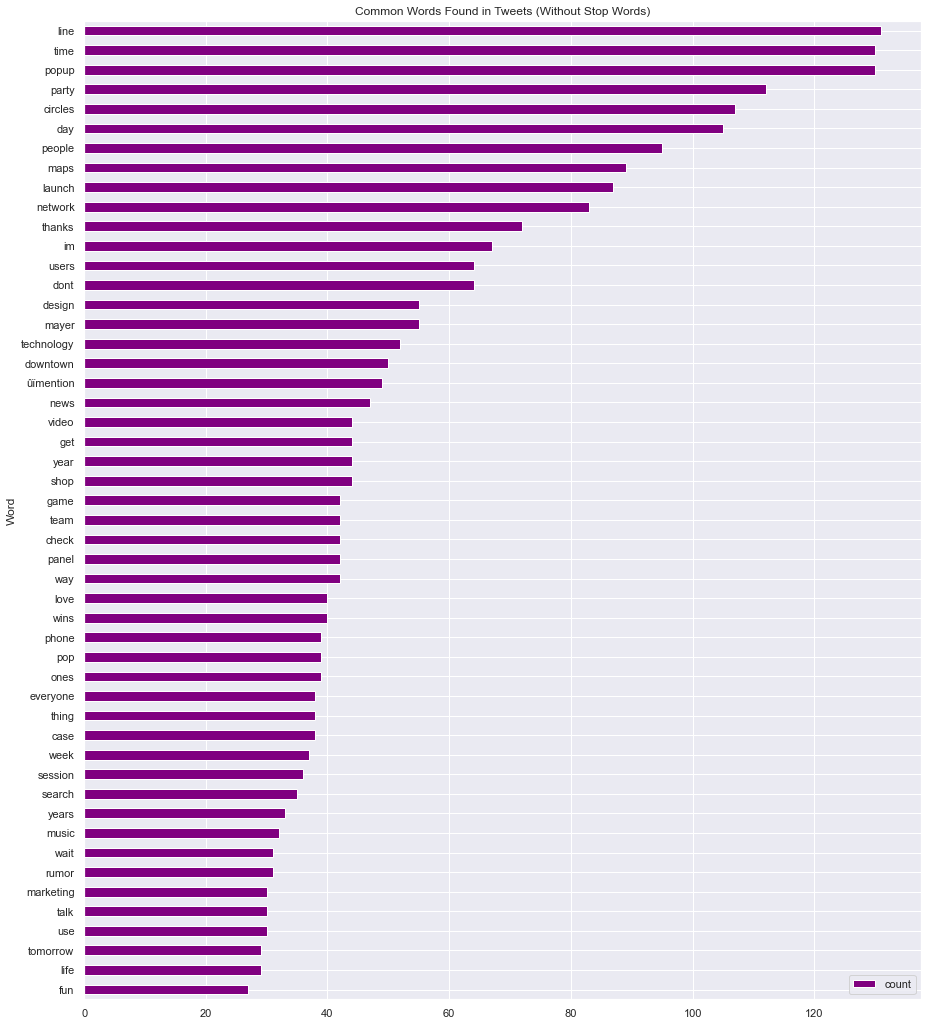

In [126]:
# The chart shows top 50 words - without stop words
fig, ax = plt.subplots(figsize=(15,18))
top_words_df.sort_values(by='count').plot.barh(x='Word', y='count', ax=ax, color="purple")
ax.set_title("Common Words Found in Tweets (Without Stop Words)")
plt.show()

In [71]:
# Take a look at a word cloud
import textblob
import wordcloud
from textblob import TextBlob, Word
from wordcloud import WordCloud

In [127]:
word_counts = ' '.join(top_words_df['Word'].tolist())
print(type(word_counts))

<class 'str'>


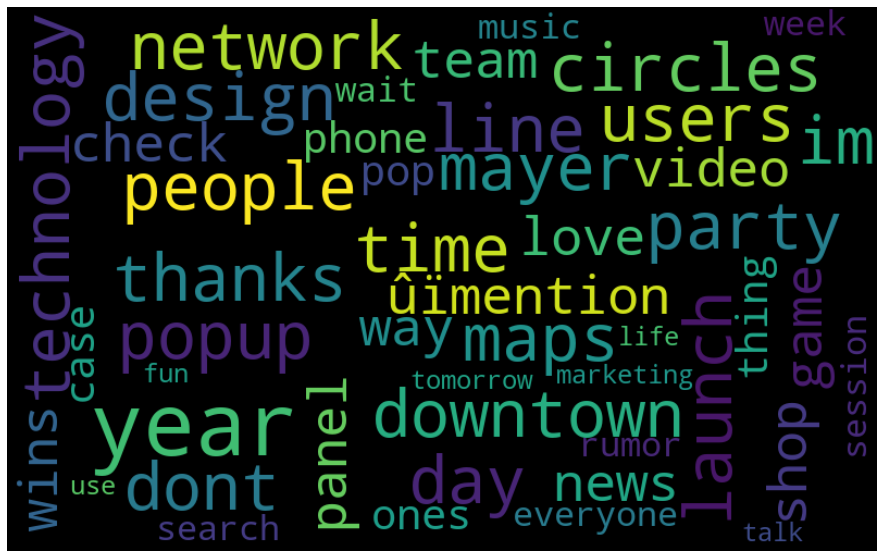

In [128]:
# Plot is of top 50 words - same data as chart above. 
plt.figure(figsize=(16,10))
wordcloud = WordCloud(width=800, height=500, max_font_size=80).generate(word_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Top Words in Tweet Set')
plt.show()

#### Observations on initial word counts
Initially, when we did not remove unique stop words, we could see from the list, barchart and word cloud that there was a lot of prodcut names and company names and a few things related to the conference process itself. Also we need to keep in mind this is for ALL texts so it is mostly the ones with positive sentiment. Also need to keep in mind that this is just the token counts... so not the result of TF-IDF or running a classificaltion model. 

UPDATE: After removing the 32 unique stopwords some terms with a bit more meaning are showing up in the chart nd word cloud. These are things like specific apps or features that launched at SXSWi - circles, maps, news, and also references to the lines and going downtown to the Apple popup store (to get the new iPad2). Later we will look at word clouds specific to the sentiment and the company. 

## On to Classification Modeling...